# CS229, Fall 2017
## Problem Set 4: EM, DL & RL
### 1. Neural Networks: MNIST image classification

#### (a)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def nn_test(data, labels, params):
    h, output, cost = forward_prop(data.T, labels.T, params)
    accuracy = compute_accuracy(output.T, labels)
    return accuracy


def compute_accuracy(output, labels):
    accuracy = (np.argmax(output, axis=1) == np.argmax(
        labels, axis=1)).sum() * 1. / labels.shape[0]
    return accuracy


def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size), labels.astype(int)] = 1
    return one_hot_labels

##### Backpropagation

For a neural network in a more general form, we define the following notations:  
* $X^{L}$: the input of layer L, a n by 1 matrix (vector)  
* $W^{L}$: the weight between layer $L$ and layer $L+1$, a m by n matrix (where m is the number of the neurons in the $L+1 $ layer and n is the number of neurons in the $L$ layer)
* $Z^{L}=W^{L}X^L$: the output of the $L$ layer, a m by 1 matrix
* $A^{L}=f(Z^{L})$: the activation output of the $L$ layer, a m by 1 matrix

Backpropagation involves 3 steps:
1. Calculate the error term of the output layer directly
2. Calculate the error term of all the other layers by using the error term of its later layer (back propagate the error)
3. Calculate the derivates using the error term

**Note: the multivariate chain rule**  
For function $z=f(x,y)$, where $x,y$ is functions of $t$, therefore we have:
$$
\frac{\partial f}{\partial t} = \frac{\partial f}{\partial x}\frac{\partial x}{\partial t} + \frac{\partial f}{\partial y}\frac{\partial y}{\partial t}
$$

###### Step 1

We define the error term as:
$$
\delta^{L} = \frac{\partial \ell}{\partial Z^{L}}
$$
where $\ell$ is the loss function. By the definition of gradient, we know that $\delta^L$ is a K by 1 matrix.
For the error term of the output layer, we begin by examing one element in that error term:
\begin{align*}
\delta_i^{L} &= \frac{\partial \ell}{\partial Z_i^{L}}\\
&= \sum_{k}\frac{\partial \ell}{\partial A_k^{L}} \frac{\partial A_k^{L}}{Z_i^{L}}\\
&= \frac{\partial \ell}{\partial A_i^L}\frac{\partial A_i^L}{Z_i^L}
\end{align*}
We take this question as an example, in this problem, the loss function $\ell$ is the cross-entropy, which has the following form:
$$
\ell = -\sum_{k=1}^Ky_k\log \hat{y}_k
$$
and also $\hat{y}_k=A_k^L=f(Z_1^L,\dots,Z_k^L,\dots, Z_K^L)$ where $f$ is the softmax function. Therefore, the above equation is:
\begin{align*}
\delta_i^{L} &= \frac{\partial \ell}{\partial A_i^L}\frac{\partial A_i^L}{Z_i^L}\\
&= -\sum_{k}^K\frac{y_k}{\hat{y}_k}\frac{\partial \hat{y}_k}{\partial Z_i^L}
\end{align*}

For the softmax function, we have:
\begin{align*}
\frac{\partial \hat{y}_k}{\partial Z_i^L}=\left\{
    \begin{matrix}
    \frac{e^{z_j}\sum_{k=1}^Ke^{z_k}-e^{2z_j}}{(\sum_{k=1}^Ke^{z_k})^2}=\frac{e^{z_j}}{\sum_{k=1}^Ke^{z_k}}-\frac{e^{z_j}}{\sum_{k=1}^Ke^{z_k}}\frac{e^{z_j}}{\sum_{k=1}^Ke^{z_k}}={\hat{y}_k(1-\hat{y}_k)}&i==k\\
    -\frac{e^{z_j+z_k}}{(\sum_{k=1}^Ke^{z_k})^2}=-\hat{y}_k\hat{y}_i&i\ne k
    \end{matrix}
\right.
\end{align*}

The complete matrix form is:
\begin{align*}
\delta^L&=\frac{\partial \ell}{\partial Z^L}\\
&= J_zA\nabla_A\ell
\end{align*}
where $J_zA$ is a K by K Jacobian matrix ($J_zA_{ik}=\frac{\partial \hat{y}_k}{\partial Z_i^L}$) and $\nabla_A\ell$ is a K by 1 vector.

We can further simplfy the above result by using the fact that $y$ is a one-hot-label, and therefore:
$$
\delta^L = \hat{y} - y
$$

###### Step 2

For all the other layers except the output layer, we have the corresponding error term as:
\begin{align*}
\delta_i^{L-1} &= \frac{\partial\ell}{\partial Z_i^{L-1}}\\
&= \sum_{k=1}^K\frac{\partial \ell}{\partial Z_k^{L}}\frac{\partial Z_k^{L}}{\partial Z_i^{L-1}}\\
&= \sum_{k=1}^K\frac{\partial \ell}{\partial Z_k^{L}}\frac{\partial Z_k^{L}}{\partial A_i^{L-1}}\frac{\partial A_i^{L-1}}{\partial Z_i^{L-1}}\\
&= \sum_{k=1}^K\delta_k^{L}W_{ki}^{L-1}\sigma(Z_i^{L-1})(1-\sigma(Z_i^{L-1}))
\end{align*}
where $\sigma(x)$ is the sigmoid function and we use the fact that $\sigma'=\sigma(1-\sigma)$

The complete matrix form is:
\begin{align*}
\delta^{L-1}={\delta^L}^TW^{L-1}\odot\bigg(\sigma(Z^{L-1})(1-\sigma(Z^{L-1}))\bigg)
\end{align*}

###### Step 3

The derivate can be calculated by:
\begin{align*}
\frac{\partial \ell}{\partial W_{ij}^{L-1}}&=\sum_{k=1}^K\frac{\partial \ell}{\partial Z_k^L}\frac{\partial Z_k^L}{\partial W_{ij}^{L-1}}\\
&=\frac{\partial \ell}{\partial Z_i^L}\frac{\partial Z_i^L}{\partial W_{ij}^{L-1}}\\
&=\delta_i^LA_j^{L-1}
\end{align*}

The complete matrix form is:
\begin{align*}
H_{W^{L-1}}\ell=\delta^L{A^{L-1}}^T
\end{align*}

In [12]:
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

For computing softmax, the overflow could easily happen due to the existence of exp function. By refering to [this implementation](https://github.com/zyxue/stanford-cs231n/blob/master/assignment1/cs231n/classifiers/softmax.py#L65) we can avoid this by subtracting the maximum value of all components of $x$ from all components in $x$:
$$
{\rm{softmax}}(x)_i=\frac{e^{x_i}}{\sum_j e^{x_j}}=\frac{e^{x_i-C}}{\sum_j e^{x_j-C}}=\frac{e^{x_i}e^C}{e^C\sum_j e^{x_j}}=\frac{e^{x_i}}{\sum_j e^{x_j}}
$$

In [13]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    # YOUR CODE HERE
    max_value = np.max(x, 0)
    s = np.exp(x - max_value) / np.sum(np.exp(x - max_value), 0)
    # END YOUR CODE
    return s


def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    # YOUR CODE HERE
    s = 1 / (1 + np.exp(-x))
    # END YOUR CODE
    return s


def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    # YOUR CODE HERE
    '''
    data: a n by m vector, where n = 784 and m is the number of data
    W1: a k by n matrix, where k = 300 is the number of hidden units
    W2: a 10 by k matrix
    '''
    # 1. Input layer to the hidden layer
    h = sigmoid(((W1 @ data).T + b1.reshape(-1)).T)

    # 2. Hidden layer to output layer
    y = softmax(((W2 @ h).T + b2.reshape(-1)).T)

    # 3. Compute the cost
    cost = -np.sum(labels * np.log(y))

    # END YOUR CODE
    return h, y, cost

In [30]:
def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    # YOUR CODE HERE
    # First, we do a forward propagation
    h, y, cost = forward_prop(data, labels, params)

    # Second, we calculate all error
    delta_2 = y - labels
    
    # Propagate backward
    delta_1 = (delta_2.T @ W2).T * (h * (1 - h))

    # Get the gradient
    gradW1 = delta_1 @ data.T
    gradb1 = np.sum(delta_1, 1).reshape(-1, 1)
    gradW2 = delta_2 @ h.T
    gradb2 = np.sum(delta_2, 1).reshape(-1, 1)
    # END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

In [35]:
def nn_train(trainData, trainLabels, devData, devLabels, lamb = 0):
    print('Training begin')
    (m, n) = trainData.shape
    num_hidden = 300
    learning_rate = 5
    params = {}

    # YOUR CODE HERE    
    B = 1000 # Mini batch size
    iteration_per_epoch = m / 1000
    epoch_round = 30
    train_error_history = [0] * epoch_round
    dev_error_history = [0] * epoch_round
    train_accuracy_history = [0] * epoch_round
    dev_accuracy_history = [0] * epoch_round
    
    # Initialize the parameter
    params['b1'] = np.zeros([num_hidden, 1])
    params['b2'] = np.zeros([10, 1])
    params['W1'] = np.random.randn(num_hidden, n)
    params['W2'] = np.random.randn(10, num_hidden)
    
    for i in range(epoch_round):
        print('Epoch %d begin' % (i + 1))
        for j in range(int(iteration_per_epoch)):
            # One batch
            batch_data = np.array(trainData[j * B:(j + 1) * B]).T
            batch_label = np.array(trainLabels[j * B:(j + 1) * B]).T
            grad = backward_prop(batch_data, batch_label, params)
            # Update parameter
            for k in params:
                if k == 'W1' or k == 'W2':
                    params[k] = params[k] - (learning_rate / B) * grad[k] - 2 * learning_rate * lamb * params[k]
                else:
                    params[k] -= (learning_rate / B) * grad[k]
        # Calculate error averaged over the entire data set
        _, train_y, train_error_history[i] = forward_prop(trainData.T, trainLabels.T, params)
        train_error_history[i] /= m
        train_accuracy_history[i] = compute_accuracy(output=train_y.T, labels=trainLabels)
        _, dev_y, dev_error_history[i] = forward_prop(devData.T, devLabels.T, params)
        dev_error_history[i] /= m
        dev_accuracy_history[i] = compute_accuracy(output=dev_y.T, labels=devLabels)
        
    # Plot the image
    # Error
    plt.plot(range(1, epoch_round + 1), train_error_history, label = 'training set')
    plt.plot(range(1, epoch_round + 1), dev_error_history, label = 'dev set')
    plt.legend()
    plt.title('Error')
    
    # Accuracy
    plt.figure()
    plt.plot(range(1, epoch_round + 1), train_accuracy_history, label = 'training set')
    plt.plot(range(1, epoch_round + 1), dev_accuracy_history, label = 'dev set')
    plt.legend()
    plt.title('Accuracy')
    # END YOUR CODE

    return params

In [16]:
def save_params(params):
    for param in params:
        np.savetxt("./params/" + param, params[param])
        
def load_params():
    params = {}
    params['b1'] = np.loadtxt('./params/b1')
    params['b2'] = np.loadtxt('./params/b2')
    params['W1'] = np.loadtxt('./params/W1')
    params['W2'] = np.loadtxt('./params/W2')
    return params

In [17]:
np.random.seed(100)
print('Begin loading data')
trainData, trainLabels = readData(
    './data/images_train.csv', './data/labels_train.csv')
trainLabels = one_hot_labels(trainLabels)
p = np.random.permutation(60000)
trainData = trainData[p, :]
trainLabels = trainLabels[p, :]

devData = trainData[0:10000, :]
devLabels = trainLabels[0:10000, :]
trainData = trainData[10000:, :]
trainLabels = trainLabels[10000:, :]

mean = np.mean(trainData)
std = np.std(trainData)
trainData = (trainData - mean) / std
devData = (devData - mean) / std

testData, testLabels = readData(
    './data/images_test.csv', './data/labels_test.csv')
testLabels = one_hot_labels(testLabels)
testData = (testData - mean) / std
print('Loading end')

Begin loading data
Loading end


Begin training
Training begin
Epoch 1 begin
Epoch 2 begin
Epoch 3 begin
Epoch 4 begin
Epoch 5 begin
Epoch 6 begin
Epoch 7 begin
Epoch 8 begin
Epoch 9 begin
Epoch 10 begin
Epoch 11 begin
Epoch 12 begin
Epoch 13 begin
Epoch 14 begin
Epoch 15 begin
Epoch 16 begin
Epoch 17 begin
Epoch 18 begin
Epoch 19 begin
Epoch 20 begin
Epoch 21 begin
Epoch 22 begin
Epoch 23 begin
Epoch 24 begin
Epoch 25 begin
Epoch 26 begin
Epoch 27 begin
Epoch 28 begin
Epoch 29 begin
Epoch 30 begin
Training end, result saved in ./params/
Test accuracy: 0.934700


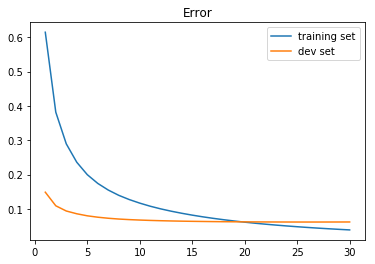

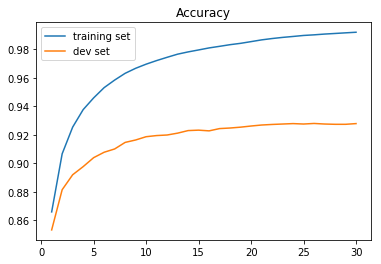

In [25]:
train = True
if train:
    print('Begin training')
    params = nn_train(trainData, trainLabels, devData, devLabels)
    save_params(params)
    print('Training end, result saved in ./params/')
else:
    print('Loading learned parameters')
    params = load_params()
    print('Loading end')
    

readyForTesting = True
if readyForTesting:
        accuracy = nn_test(testData, testLabels, params)
        print('Test accuracy: %f' % accuracy)

#### (b)

First, we modify the code in function 'nn_train', we add an extra parameter 'lamb' which indicates the regularization $\lambda$. We set its default value to be 0, which is equivalent to not using regularization.

Now, we re-implement the training code as follows:

Begin training
Training begin
Epoch 1 begin
Epoch 2 begin
Epoch 3 begin
Epoch 4 begin
Epoch 5 begin
Epoch 6 begin
Epoch 7 begin
Epoch 8 begin
Epoch 9 begin
Epoch 10 begin
Epoch 11 begin
Epoch 12 begin
Epoch 13 begin
Epoch 14 begin
Epoch 15 begin
Epoch 16 begin
Epoch 17 begin
Epoch 18 begin
Epoch 19 begin
Epoch 20 begin
Epoch 21 begin
Epoch 22 begin
Epoch 23 begin
Epoch 24 begin
Epoch 25 begin
Epoch 26 begin
Epoch 27 begin
Epoch 28 begin
Epoch 29 begin
Epoch 30 begin
Training end, result saved in ./params/
Test accuracy: 0.965300


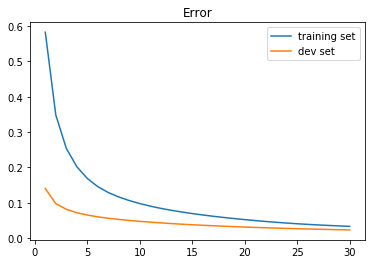

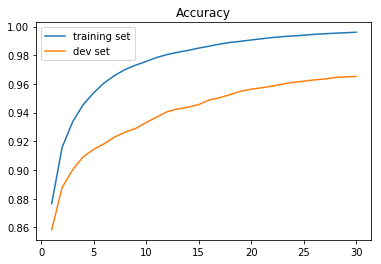

In [36]:
train = True
if train:
    print('Begin training')
    params = nn_train(trainData, trainLabels, devData, devLabels, lamb=0.0001)
    save_params(params)
    print('Training end, result saved in ./params/')
else:
    print('Loading learned parameters')
    params = load_params()
    print('Loading end')
    

readyForTesting = True
if readyForTesting:
        accuracy = nn_test(testData, testLabels, params)
        print('Test accuracy: %f' % accuracy)

As we can see from above, apparently that the neural network with regularization generalize better than the neural network without regularization (this can be seen because for the regularized network, both the training error and training accuracy imporved on the dev set).

#### (c)

As we have calculated above, the accuracy on the test set for two different kinds of neural networks are $0.934700$ (without regularization) and $0.965300$ (with regularization). So it is quite apparently that regularization helps our model generalize better!